In [ ]:
#https://www.kaggle.com/huanntran100/spotify-song-popularity-prediction/data

In [ ]:
!pip3 install kneed

In [ ]:
import numpy as np 
import pandas as pd
import seaborn as sns
from scipy import stats
import plotly
import plotly.express as px
import plotly.graph_objects as go
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
from mpl_toolkits.mplot3d import Axes3D
import plotnine
from plotnine import *
import itertools
import math
from prettytable import PrettyTable
from sklearn import preprocessing
from sklearn.cluster import KMeans, MeanShift
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.mixture import GaussianMixture
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVR
from sklearn.decomposition import PCA
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RepeatedStratifiedKFold
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score, silhouette_score
from sklearn.metrics import plot_roc_curve, balanced_accuracy_score
from xgboost import XGBClassifier
import xgboost as xgb
from scipy.spatial import distance
from imblearn.over_sampling import SMOTE
from kneed import KneeLocator
import copy
import warnings
warnings.filterwarnings("ignore")
plotly.offline.init_notebook_mode(connected = True)
%matplotlib inline
sns.set(style = "ticks", context = "talk")

In [ ]:
data = pd.read_csv("/content/SpotifyFeatures.csv")
data.head()

,genre,artist_name,track_name,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence
0,Opera,Giuseppe Verdi,"Stiffelio, Act III: Ei fugge! … Lina, pensai c...",7EsKYeHtTc4H4xWiTqSVZA,21,0.986,0.313,490867,0.23100,0.000431,C#,0.0964,-14.287,Major,0.0547,86.001,4/4,0.0886
1,Opera,Giacomo Puccini,Madama Butterfly / Act 1: ... E soffitto e pareti,7MfmRBvqaW0I6UTxXnad8p,18,0.972,0.360,176797,0.20100,0.028000,D#,0.1330,-19.794,Major,0.0581,131.798,4/4,0.3690
2,Opera,Giacomo Puccini,"Turandot / Act 2: Gloria, gloria, o vincitore",7pBo1GDhIysyUMFXiDVoON,10,0.935,0.168,266184,0.47000,0.020400,C,0.3630,-8.415,Major,0.0383,75.126,3/4,0.0696
3,Opera,Giuseppe Verdi,"Rigoletto, Act IV: Venti scudi hai tu detto?",02mvYZX5aKNzdqEo6jF20m,17,0.961,0.250,288573,0.00605,0.000000,D,0.1200,-33.440,Major,0.0480,76.493,4/4,0.0380
4,Opera,Giuseppe Verdi,"Don Carlo / Act 4: ""Ella giammai m'amò!""",03TW0jwGMGhUabAjOpB1T9,19,0.985,0.142,629760,0.05800,0.146000,D,0.0969,-23.625,Major,0.0493,172.935,4/4,0.0382


# Feature Engineering

### Combine Duplicated Songs Over the Years

Some songs appeared multiple times in the data frame, so here we will combine the songs that appeared multiple times by avaging their numeric features(effectively only the popularity column) over the all apperances 

In [ ]:
data_numeric_no_duplicated = data.groupby('track_id', as_index=False).mean()
print(data_numeric_no_duplicated.shape)
data_category_no_duplicated = data.select_dtypes(include=['object']).drop_duplicates(subset=['track_id'])
print(data_category_no_duplicated.shape)
data = data_numeric_no_duplicated.merge(data_category_no_duplicated,on='track_id')
data

(153685, 12)
(153685, 7)


,track_id,popularity,acousticness,danceability,duration_ms,energy,instrumentalness,liveness,loudness,speechiness,tempo,valence,genre,artist_name,track_name,key,mode,time_signature
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.249,0.518,130653.0,0.805,0.000000,0.3330,-6.248,0.0407,79.124,0.841,Movie,Henri Salvador,Coeur Brisé à Prendre - Remastered,F,Major,4/4
1,000DfZJww8KiixTKuk9usJ,30.0,0.366,0.631,357573.0,0.513,0.000004,0.1090,-6.376,0.0293,120.365,0.307,Reggae,Mike Love,Earthlings,D,Major,4/4
2,000EWWBkYaREzsBplYjUag,39.0,0.815,0.768,104924.0,0.137,0.922000,0.1130,-13.284,0.0747,76.430,0.560,Jazz,Don Philippe,Fewerdolr,C#,Minor,4/4
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.131,0.748,188491.0,0.627,0.000000,0.0852,-6.029,0.0644,120.963,0.524,Dance,ZAYN,Still Got Time,G,Major,4/4
4,0017XiMkqbTfF2AUOzlhj6,27.0,0.792,0.536,127040.0,0.780,0.000000,0.7350,-9.449,0.9450,173.912,0.452,Comedy,Chad Daniels,Thanksgiving Chicken,F,Minor,3/4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.833,0.353,273800.0,0.383,0.000131,0.1100,-8.232,0.0267,172.842,0.287,World,Hillsong Worship,Emmanuel,C#,Minor,3/4
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.400,0.851,251267.0,0.790,0.230000,0.1230,-4.641,0.0309,111.993,0.889,Jazz,Caravan Palace,Maniac,C,Minor,4/4
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.973,0.538,266933.0,0.144,0.177000,0.3590,-17.711,0.0569,135.640,0.110,Jazz,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,G#,Major,3/4
153683,7zzTeItz93lYI52hlcipm5,28.0,0.113,0.716,228493.0,0.806,0.000000,0.1510,-5.913,0.1350,136.069,0.544,Reggaeton,Magnate Y Valentino,Una En Un Millón,G,Minor,4/4


### Drop unneeded data

In [ ]:
# Get rid of tracks too long or too short because data containes podcast
data = data[np.abs(stats.zscore(data['duration_ms'])) <= 3]
# Drop duration becuase it is not an audio feature 
data = data.drop(['duration_ms'], axis=1)
# Drop comedy category because they are not songs
data = data[~(data["genre"] == "Comedy")]
# Drop key becuase it is not an relavent audio feature
data = data.drop(['key'], axis=1)
# Drop mode because it is not an relavent audio feature except that minor songs 
# tend to be more nagative/sad and major ones are more positive and happy however
# the valence feature also provide the same information
data = data.drop(['mode'], axis=1)
# Drop time_signature because most values are "4/4"
data = data.drop(['time_signature'], axis=1)
# Drop instrumentalness because most values are close to 0
data = data.drop(['instrumentalness'], axis=1)
# Drop energy because energy and loudness are highly corelated and loundness is more corelated to popularity
data = data.drop(['energy'], axis=1)
# Kepp an id df
data_id = data[["artist_name", "track_name", "track_id", "genre", "popularity"]]
# Copy a cleaned data the contains all the valid songs
data_all = data.copy()
# Drop other not needed features
data = data.drop(["artist_name", "track_name"], axis=1)

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 142683 entries, 0 to 153684
Data columns (total 10 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   track_id      142683 non-null  object 
 1   popularity    142683 non-null  float64
 2   acousticness  142683 non-null  float64
 3   danceability  142683 non-null  float64
 4   liveness      142683 non-null  float64
 5   loudness      142683 non-null  float64
 6   speechiness   142683 non-null  float64
 7   tempo         142683 non-null  float64
 8   valence       142683 non-null  float64
 9   genre         142683 non-null  object 
dtypes: float64(8), object(2)
memory usage: 12.0+ MB


In [ ]:
data.describe()

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
count,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000
mean,39.681628,0.382980,0.540679,0.194257,-10.163494,0.086237,117.551059,0.441665
std,16.901008,0.363308,0.196970,0.168404,6.609099,0.095386,31.022450,0.270136
min,0.000000,0.000001,0.056900,0.009670,-52.457000,0.022200,30.379000,0.000000
25%,29.000000,0.041850,0.404000,0.096000,-12.725500,0.036500,92.510000,0.206000
50%,41.000000,0.247000,0.561000,0.123000,-7.972000,0.047600,115.475000,0.425000
75%,51.000000,0.753000,0.693000,0.236000,-5.590000,0.087100,139.509000,0.661000
max,100.000000,0.996000,0.987000,1.000000,1.585000,0.965000,239.848000,1.000000


### Normalize Numeric features

Use min max because all the numberical features has an upper and lower bound

In [ ]:
sc = MinMaxScaler()
# get numeric data
num_data = data.select_dtypes(exclude=['object'])
num_data = num_data.drop(['popularity'], axis=1)
# update the cols with their normalized values
data[num_data.columns] = sc.fit_transform(num_data)
data

,track_id,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,genre
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,Movie
1,000DfZJww8KiixTKuk9usJ,30.0,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,Reggae
2,000EWWBkYaREzsBplYjUag,39.0,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,Jazz
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,Dance
5,001KkOBeRiQ1J7IEJYHODW,31.0,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,World
...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,World
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,Jazz
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,Jazz
153683,7zzTeItz93lYI52hlcipm5,28.0,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,Reggaeton


### Encode categorical features

In [ ]:
# # Using one-hot encoding because these categorical features are nominal
# data = data.drop(["genre", "track_id"], axis=1)
# data = pd.get_dummies(data)
# data

In [ ]:
data.describe()

,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
count,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000,142683.000000
mean,39.681628,0.384517,0.520136,0.186389,0.782604,0.067923,0.416157,0.441665
std,16.901008,0.364767,0.211773,0.170048,0.122296,0.101174,0.148100,0.270136
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,29.000000,0.042017,0.373186,0.087173,0.735197,0.015168,0.296612,0.206000
50%,41.000000,0.247991,0.541985,0.114437,0.823156,0.026941,0.406246,0.425000
75%,51.000000,0.756024,0.683905,0.228540,0.867233,0.068838,0.520984,0.661000
max,100.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


# GMM

We decided to use GMM because K-Means classifies each songs to one and only one cluster while GMM gives a probability of the songs being in a cluster for every cluster. In other words, we can classify a song to be in multiple clusters rather than one, which is better because a songs can have multiple different characteristics.



### Find the optimal number of clusters 

In [ ]:
def SelBest(arr:list, X:int)->list:
    '''
    returns the set of X configurations with shorter distance
    '''
    dx=np.argsort(arr)[:X]
    return arr[dx]

In [ ]:
# Bayesian Information Criterion (BIC)
X = data._get_numeric_data().drop(["popularity"], axis=1)

# Try cluster number 2 to 20
n_clusters = np.arange(2, 20)

# Run the each gmm with a specific number of cluster 10 times to  
# choose the best 5 run results 
iterations = 10

bics = []
bics_err = []
for n in n_clusters:
    tmp_bic=[]
    for i in range(iterations):
        gmm = GaussianMixture(n).fit(X) 
        bic = gmm.bic(X)
        tmp_bic.append(bic)
    # The mean value and the standard deviation of the best five runs
    val = np.mean(SelBest(np.array(tmp_bic), int(iterations/5)))
    err = np.std(tmp_bic)
    bics.append(val)
    bics_err.append(err)    

7


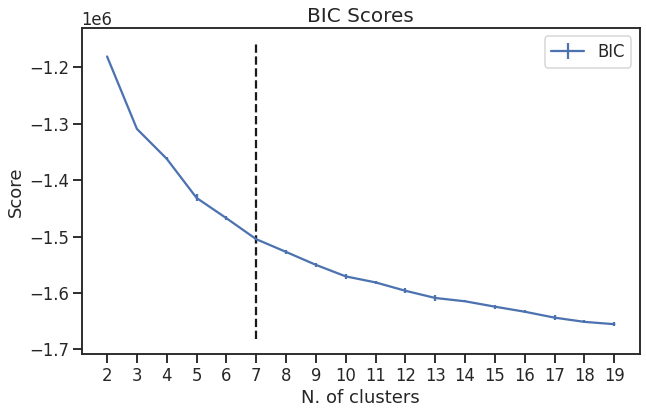

In [ ]:
kn = KneeLocator(n_clusters, bics, curve='convex', direction='decreasing')
print(kn.knee)

plt.figure(figsize=(10, 6))
plt.errorbar(n_clusters, bics, yerr=bics_err, label='BIC')
plt.vlines(kn.knee, plt.ylim()[0], plt.ylim()[1], linestyles='dashed')
plt.title("BIC Scores", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")
plt.legend()

In [ ]:
# Silhouette Score(use 5% of the data becuase the whole set will take days it takes too long to run)
X = data._get_numeric_data().drop(["popularity"], axis=1).sample(frac = 0.05)

# Try cluster number 2 to 20
n_clusters = np.arange(2, 20)

# Run the each gmm with a specific number of cluster 10 times to  
# choose the best 5 run results 
iterations = 10

sils=[]
sils_err=[]
for n in n_clusters:
    tmp_sil=[]
    for i in range(iterations):
        gmm = GaussianMixture(n).fit(X) 
        labels = gmm.predict(X)
        sil = silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
    # The mean value and the standard deviation of the best five runs
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err = np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)    
    

Text(0, 0.5, 'Score')

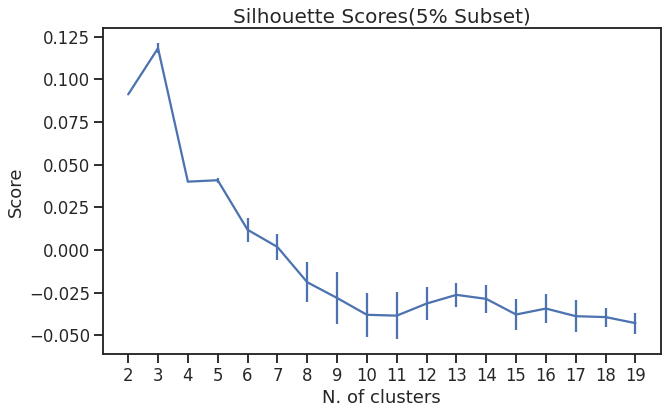

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores(5% Subset)", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

In [ ]:
# Silhouette Score(use 10% of the data becuase the whole set will take days it takes too long to run)
X = data._get_numeric_data().drop(["popularity"], axis=1).sample(frac = 0.1)

# Try cluster number 2 to 20
n_clusters = np.arange(2, 20)

# Run the each gmm with a specific number of cluster 10 times to  
# choose the best 5 run results 
iterations = 10

sils=[]
sils_err=[]
for n in n_clusters:
    tmp_sil=[]
    for i in range(iterations):
        gmm = GaussianMixture(n).fit(X) 
        labels = gmm.predict(X)
        sil = silhouette_score(X, labels, metric='euclidean')
        tmp_sil.append(sil)
    # The mean value and the standard deviation of the best five runs
    val = np.mean(SelBest(np.array(tmp_sil), int(iterations/5)))
    err = np.std(tmp_sil)
    sils.append(val)
    sils_err.append(err)    
    

Text(0, 0.5, 'Score')

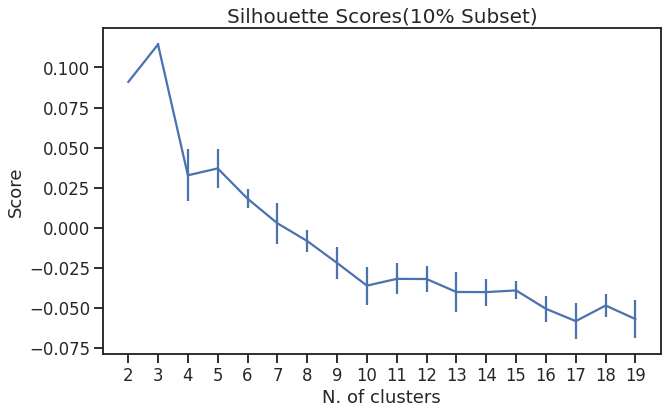

In [ ]:
plt.figure(figsize=(10, 6))
plt.errorbar(n_clusters, sils, yerr=sils_err)
plt.title("Silhouette Scores(10% Subset)", fontsize=20)
plt.xticks(n_clusters)
plt.xlabel("N. of clusters")
plt.ylabel("Score")

We can see that the Silhouette Scores for both the 5% and the 10% subsets has a very siilar trend, suggesting that subsetting is okay. For both runs, we can see that when number of cluster is 3, the score is maximized, however, we want to have more than 3 categories for the listeners to choose from, therefore, we are deciding on number of clusters to be 5 as it is the next best scores

### Final Model

In [ ]:
# Final model
n = 5
X = data._get_numeric_data().drop(["popularity"], axis=1)
gmm = GaussianMixture(n).fit(X)
X

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110
...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544


In [ ]:
data_clustered = X.copy()
data_clustered["cluster"] = gmm.predict(data_clustered)
data_clustered

,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,cluster
0,0.249999,0.495753,0.326487,0.855057,0.019622,0.232707,0.841,2
1,0.367469,0.617245,0.100300,0.852689,0.007531,0.429591,0.307,4
2,0.818273,0.764541,0.104339,0.724862,0.055685,0.219846,0.560,4
3,0.131525,0.743038,0.076268,0.859110,0.044760,0.432446,0.524,4
5,0.069979,0.238792,0.088587,0.796473,0.007425,0.478582,0.110,2
...,...,...,...,...,...,...,...,...
153680,0.836345,0.318353,0.101310,0.818345,0.004773,0.680115,0.287,0
153681,0.401606,0.853779,0.114437,0.884793,0.009228,0.389623,0.889,4
153682,0.976908,0.517256,0.352741,0.642944,0.036805,0.502513,0.110,3
153683,0.113453,0.708633,0.142710,0.861256,0.119644,0.504562,0.544,3


In [ ]:
data_clustered.groupby('cluster').size().reset_index(name='Num of songs')

,cluster,Num of songs
0,0,22501
1,1,22078
2,2,28606
3,3,34106
4,4,35392


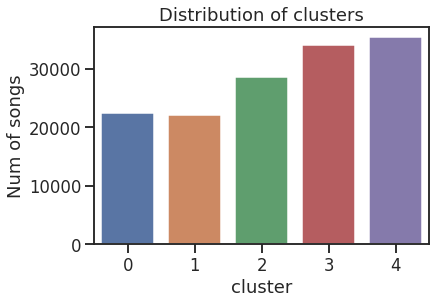

In [ ]:
cluster_size = data_clustered.groupby('cluster').size().reset_index(name='Num of songs')
sns.barplot(data=cluster_size, x='cluster', y='Num of songs',)
plt.title('Distribution of clusters')
plt.show()

In [ ]:
cluster = 0
data_id[data_clustered['cluster'] == cluster].sort_values(by=['popularity'], ascending=False).head(10)

,artist_name,track_name,track_id,genre,popularity
28918,Ariana Grande,needy,1TEL6MlSSVLSdhOSddidlJ,Pop,92.0
147736,Billie Eilish,ocean eyes,7hDVYcQq6MxkdJGweuCtl9,Pop,86.0
68710,John Legend,All of Me,3U4isOIWM3VvDubwSI3y7a,Soul,85.0
31256,Alex & Sierra,Little Do You Know,1almCHdsfikRPfVB9VrEdT,Pop,81.0
89192,Ed Sheeran,Supermarket Flowers,4VuS959DSpr82t3qBqCrWG,Pop,80.0
140826,Rihanna,FourFiveSeconds,78TTtXnFQPzwqlbtbwqN0y,Pop,80.0
128517,A Great Big World,Say Something,6Vc5wAMmXdKIAM7WUoEb7N,Pop,80.0
24670,Lauv,Superhero,1Fo4OvzP9PThFKMeMIAEYu,Pop,79.0
51162,Aitana,Vas A Quedarte,2b3JxLi8KAiOsD8ehnOxDZ,Pop,79.0
28868,Julia Michaels,Heaven,1T575AhHueYinKSDflEsGK,Pop,79.0


### Coming up with labels for the clusters

In [ ]:
pca = PCA(random_state=123)
pca_results = pca.fit_transform(X)
print(pca.explained_variance_ratio_)
pca.explained_variance_ratio_.cumsum()

[0.55279786 0.18514497 0.09070133 0.06961974 0.05665268 0.0274166
 0.01766682]


array([0.55279786, 0.73794283, 0.82864416, 0.8982639 , 0.95491658,
       0.98233318, 1.        ])

In [ ]:
df_pca = pd.DataFrame(pca_results, index=X.index)
df_pca['cluster'] = data_clustered["cluster"]
df_pca = pd.concat([df_pca, data_id],axis=1)
df_pca

,0,1,2,3,4,5,6,cluster,artist_name,track_name,track_id,genre,popularity
0,-0.272520,0.213744,0.177270,-0.010972,-0.292669,-0.020864,-0.037850,2,Henri Salvador,Coeur Brisé à Prendre - Remastered,000CzNKC8PEt1yC3L8dqwV,Movie,5.0
1,0.000243,-0.076020,-0.129690,-0.059145,0.087269,-0.086404,-0.053179,4,Mike Love,Earthlings,000DfZJww8KiixTKuk9usJ,Reggae,30.0
2,0.244441,0.429398,-0.126190,-0.220821,0.008474,-0.041106,-0.007316,4,Don Philippe,Fewerdolr,000EWWBkYaREzsBplYjUag,Jazz,39.0
3,-0.326872,0.004989,-0.157253,-0.052791,0.047806,-0.050549,0.005013,4,ZAYN,Still Got Time,000xQL6tZNLJzIrtIgxqSl,Dance,70.0
5,-0.011992,-0.522919,-0.083077,0.141987,-0.068793,-0.004395,-0.001622,2,C3 Music,The Father's Love - Live,001KkOBeRiQ1J7IEJYHODW,World,31.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
153680,0.468796,0.047771,-0.007346,0.266903,0.193640,-0.062484,-0.127356,0,Hillsong Worship,Emmanuel,7zz3cHALU9cj7Io5qINt1R,World,21.0
153681,-0.309278,0.464461,-0.084581,-0.040676,-0.002292,-0.098788,-0.039213,4,Caravan Palace,Maniac,7zz7MbCb9G7KJc1NVl9bL0,Jazz,38.0
153682,0.633342,0.066197,0.132923,-0.103698,0.273049,-0.083082,0.033998,3,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...,7zzFNNxVD0h0ctAT08H0pa,Jazz,40.0
153683,-0.351605,-0.006534,-0.071057,-0.006303,0.094748,0.017264,0.005545,3,Magnate Y Valentino,Una En Un Millón,7zzTeItz93lYI52hlcipm5,Reggaeton,28.0


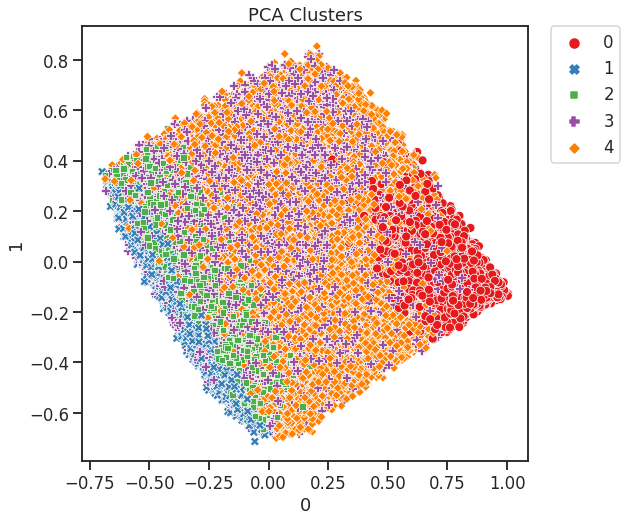

In [ ]:
fig, ax = plt.subplots(figsize=(8, 8))
sns.scatterplot(data=df_pca, x=0, y=1, hue='cluster', style='cluster', palette='Set1')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.title('PCA Clusters')
plt.show()

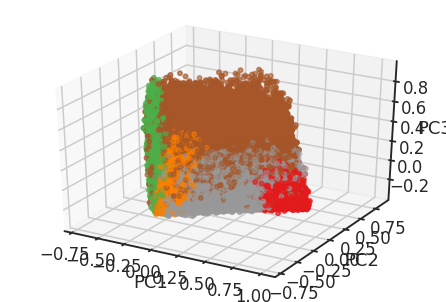

In [ ]:
fig = plt.figure()
ax = Axes3D(fig)

ax.scatter(df_pca[0], df_pca[1], df_pca[2],
           c=df_pca['cluster'], cmap='Set1')

ax.set_xlabel('PC1')
ax.set_ylabel('PC2')
ax.set_zlabel('PC3')
plt.show()

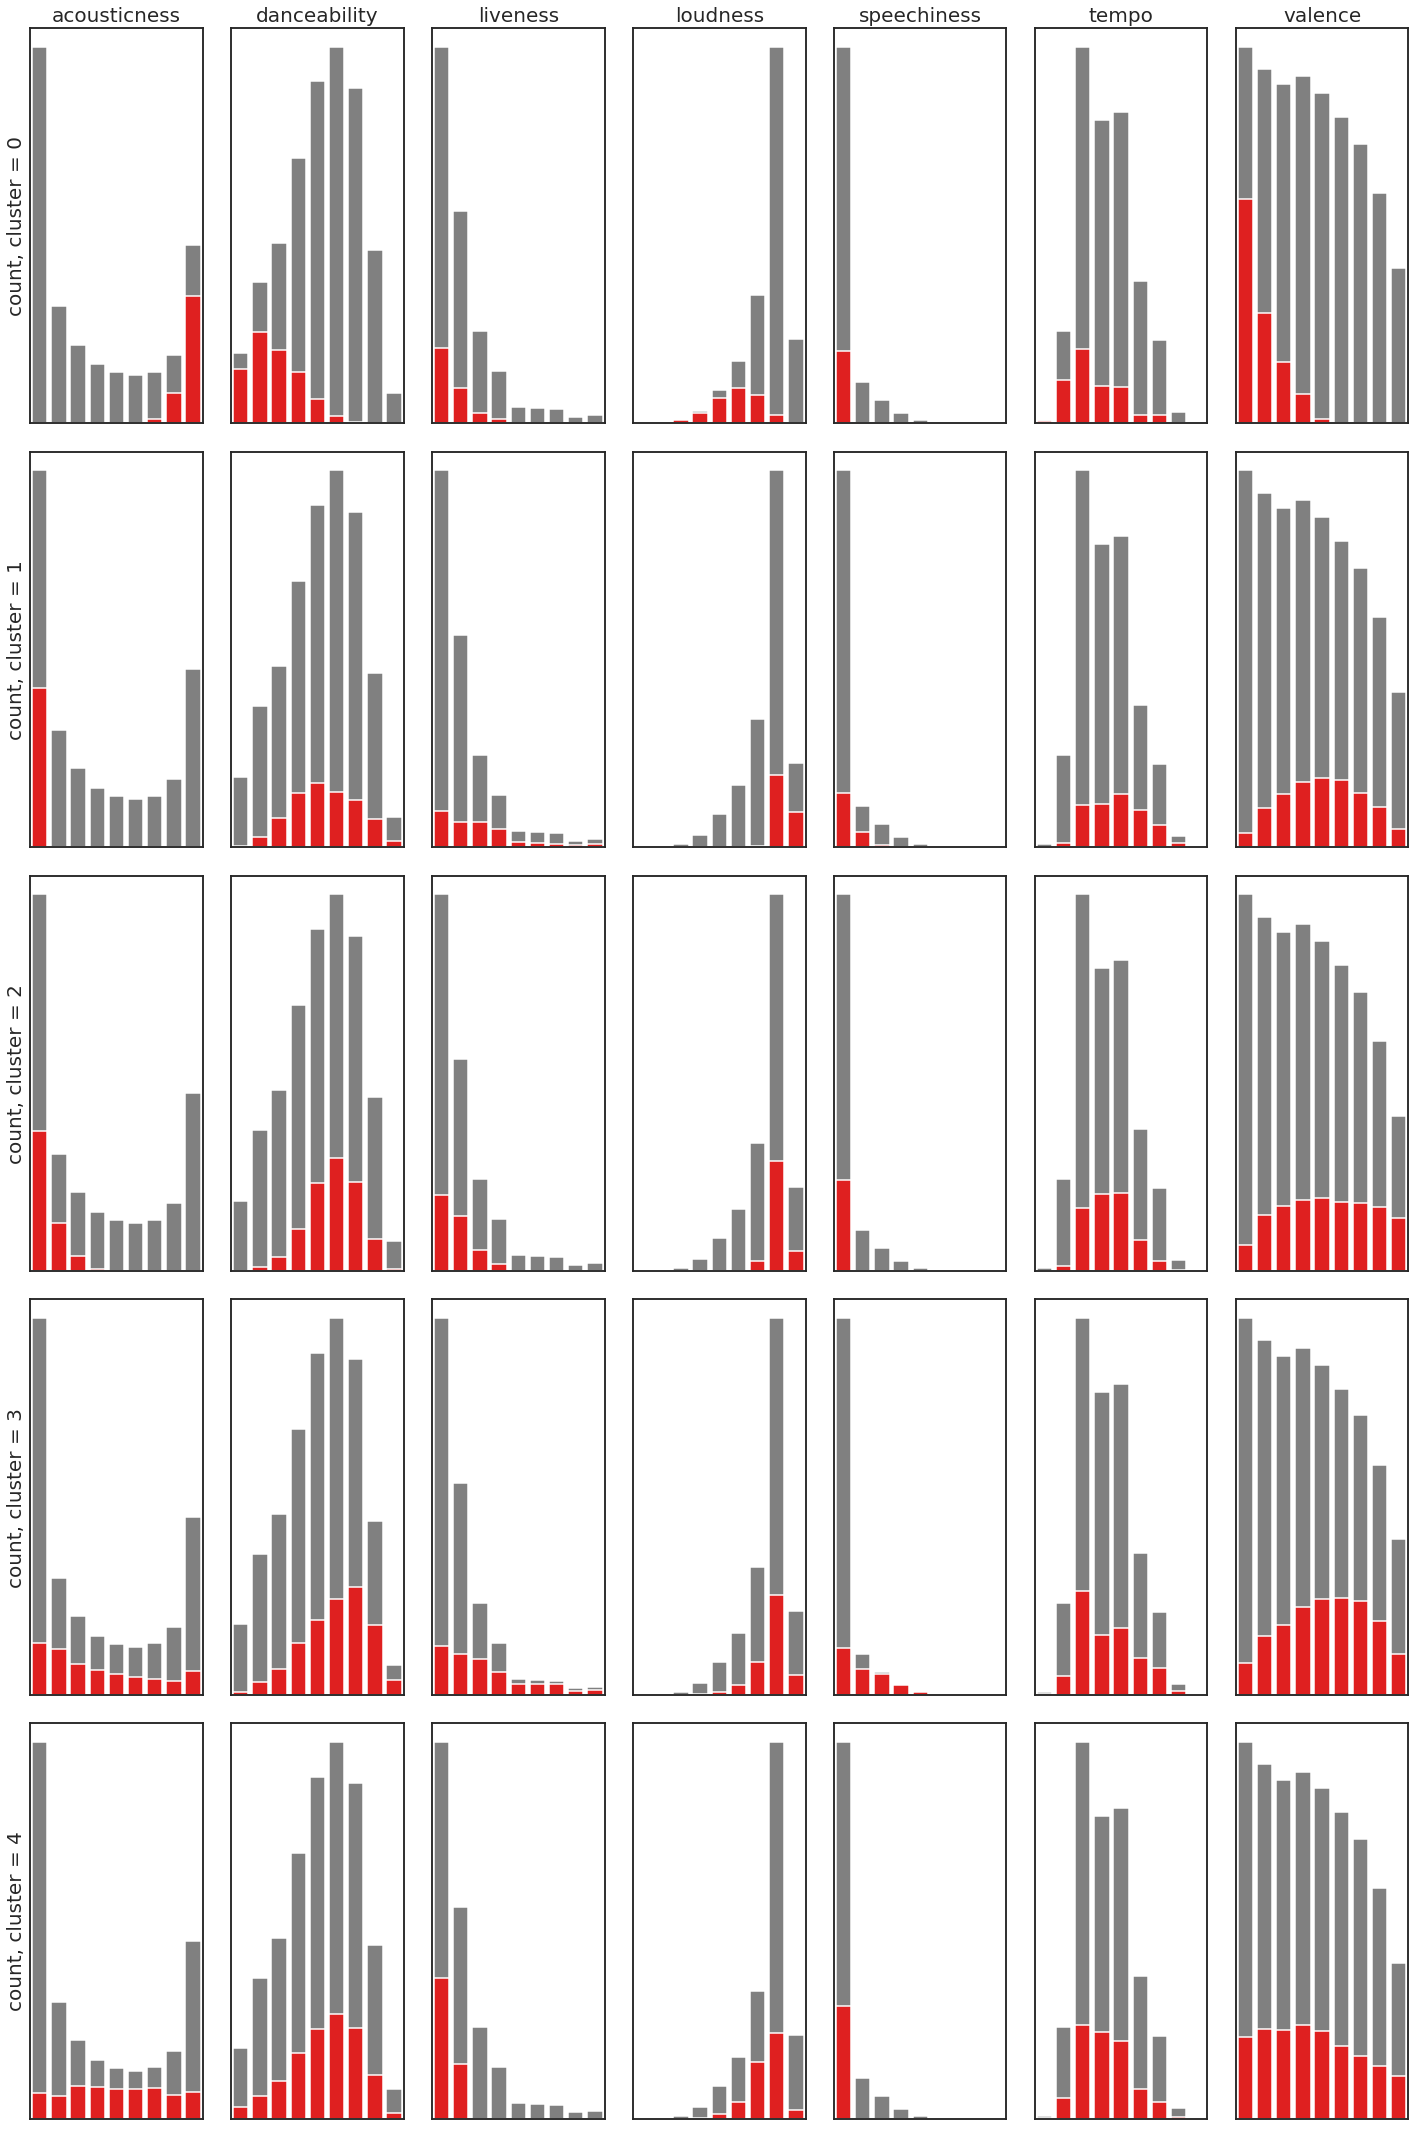

In [ ]:
# set binning intervals 
bins = np.linspace(0,1,10)

# create subplots
num_features = len(X.columns)
f, axes = plt.subplots(n, num_features, 
                       figsize=(20, 30), sharex='col')

# initialise 1st row. Representing cluster
row = 0
for cluster in np.sort(data_clustered['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = data_clustered[data_clustered['cluster'] == cluster]
    col = 0
    
    for feature in X.columns:
#         create binned count for all recent df and clustered df
        rec_grp = data_clustered.groupby(pd.cut(data_clustered[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', 
                    color='grey', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', 
                    color='red', ax=axes[row, col])
        
#         configure ax
        axes[row, col].set_xlabel('')
        axes[row, col].set_xticks([], [])
        axes[row, col].set_yticks([], [])
        if col > 0:
            axes[row, col].set_ylabel('')
        else:
            axes[row, col].set_ylabel(f'count, cluster = {cluster}' , fontsize=20)
        if row == 0:
            axes[row, col].set_title(feature, fontsize=20)        
        col += 1
    row += 1

plt.tight_layout()
plt.show()

Culster|acousticness|danceablity| liveness|loudness|speechinessss|tempo| valence|Label    
--|--|--|--|--|--|--|--|--|
0|Low|High|||Low|||Chill
1|Low||High|High||||Loud
2||High|High||High||High|Happy
3|High|Low|Low|Low|Low|Low|Low|Acoustic
4||High|Low||Low|||Dance


* Cluster 0: Chill
* Cluster 1: Loud
* Cluster 2: Happy
* Cluster 3: Acoustic 
* Cluster 4: Dance

In [ ]:
cluster_to_mood = {0: "Chill", 1: "Loud", 2: "Happy", 3: "Acoustic", 4: "Dance"}

In [ ]:
print(len(data.genre.unique()))
sorted(list(data.genre.unique()))

23


['A Capella',
 'Alternative',
 'Blues',
 'Classical',
 'Country',
 'Dance',
 'Electronic',
 'Folk',
 'Hip-Hop',
 'Indie',
 'Jazz',
 'Movie',
 'Opera',
 'Pop',
 'R&B',
 'Rap',
 'Reggae',
 'Reggaeton',
 'Rock',
 'Ska',
 'Soul',
 'Soundtrack',
 'World']

We will create a total of 1 + 5 + 23 = 29 categories. They are: 
0. All 


Mood Categories:
1. Acoustic 
2. Chill 
3. Dance
4. Happy
5. Loud 

Genres: 
6. A Capella
7. Alternative
8. Blues
9. Classical
10. Country
11. Dance
12. Electronic
13. Folk
14. Hip-Hop
15. Indie
16. Jazz
17. Movie
18. Opera
19. Pop
20. R&B
21. Rap
22. Reggae
23. Reggaeton
24. Rock
25. Ska
26. Soul
27. Soundtrack
28. World

### Generete Data Subsets

In [ ]:
data_all.to_csv("/content/SpotifyFeatures_Cleaned.csv")
data_all

,track_id,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,genre,artist_name,track_name
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.2490,0.518,0.3330,-6.248,0.0407,79.124,0.841,Movie,Henri Salvador,Coeur Brisé à Prendre - Remastered
1,000DfZJww8KiixTKuk9usJ,30.0,0.3660,0.631,0.1090,-6.376,0.0293,120.365,0.307,Reggae,Mike Love,Earthlings
2,000EWWBkYaREzsBplYjUag,39.0,0.8150,0.768,0.1130,-13.284,0.0747,76.430,0.560,Jazz,Don Philippe,Fewerdolr
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.1310,0.748,0.0852,-6.029,0.0644,120.963,0.524,Dance,ZAYN,Still Got Time
5,001KkOBeRiQ1J7IEJYHODW,31.0,0.0697,0.279,0.0974,-9.414,0.0292,130.627,0.110,World,C3 Music,The Father's Love - Live
...,...,...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.8330,0.353,0.1100,-8.232,0.0267,172.842,0.287,World,Hillsong Worship,Emmanuel
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.4000,0.851,0.1230,-4.641,0.0309,111.993,0.889,Jazz,Caravan Palace,Maniac
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.9730,0.538,0.3590,-17.711,0.0569,135.640,0.110,Jazz,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...
153683,7zzTeItz93lYI52hlcipm5,28.0,0.1130,0.716,0.1510,-5.913,0.1350,136.069,0.544,Reggaeton,Magnate Y Valentino,Una En Un Millón


In [ ]:
df_gmm_prob = pd.DataFrame(gmm.predict_proba(X), index=X.index)
df_gmm_prob

,0,1,2,3,4
0,7.929608e-34,5.189787e-46,9.164737e-01,0.083526,3.115357e-13
1,5.650763e-17,7.216870e-106,1.739063e-02,0.010481,9.721281e-01
2,1.285868e-11,0.000000e+00,5.806607e-20,0.020122,9.798785e-01
3,9.557085e-48,3.704396e-11,2.022914e-01,0.012276,7.854326e-01
5,8.253450e-39,4.115997e-06,7.333194e-01,0.000227,2.664495e-01
...,...,...,...,...,...
153680,6.921057e-01,0.000000e+00,8.812757e-18,0.001542,3.063518e-01
153681,1.273511e-22,9.983007e-121,1.055675e-02,0.030937,9.585066e-01
153682,1.502790e-01,0.000000e+00,3.822606e-24,0.849721,2.429100e-13
153683,9.092409e-106,7.462509e-06,8.103321e-19,0.998193,1.799564e-03


In [ ]:
song_to_cluster = dict()
for index, row in df_gmm_prob.iterrows():
  significant_clusters = []
  num_clusters = len(row)
  for cluster in range(num_clusters):
    if row[cluster] >= 1/num_clusters:
      significant_clusters.append(cluster_to_mood[cluster])
  song_to_cluster[index] = significant_clusters

song_to_cluster

In [ ]:
df_song_to_cluster = pd.DataFrame(song_to_cluster.values(), index=song_to_cluster.keys())
df_song_to_cluster["cluster"] = df_song_to_cluster.values.tolist()
df_song_to_cluster = df_song_to_cluster["cluster"]
df_song_to_cluster

0            [Happy, None, None]
1            [Dance, None, None]
2            [Dance, None, None]
3           [Happy, Dance, None]
5           [Happy, Dance, None]
                   ...          
153680      [Chill, Dance, None]
153681       [Dance, None, None]
153682    [Acoustic, None, None]
153683    [Acoustic, None, None]
153684      [Happy, Dance, None]
Name: cluster, Length: 142683, dtype: object

In [ ]:
data_to_sub = data_all.copy()
data_to_sub

,track_id,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,genre,artist_name,track_name
0,000CzNKC8PEt1yC3L8dqwV,5.0,0.2490,0.518,0.3330,-6.248,0.0407,79.124,0.841,Movie,Henri Salvador,Coeur Brisé à Prendre - Remastered
1,000DfZJww8KiixTKuk9usJ,30.0,0.3660,0.631,0.1090,-6.376,0.0293,120.365,0.307,Reggae,Mike Love,Earthlings
2,000EWWBkYaREzsBplYjUag,39.0,0.8150,0.768,0.1130,-13.284,0.0747,76.430,0.560,Jazz,Don Philippe,Fewerdolr
3,000xQL6tZNLJzIrtIgxqSl,70.0,0.1310,0.748,0.0852,-6.029,0.0644,120.963,0.524,Dance,ZAYN,Still Got Time
5,001KkOBeRiQ1J7IEJYHODW,31.0,0.0697,0.279,0.0974,-9.414,0.0292,130.627,0.110,World,C3 Music,The Father's Love - Live
...,...,...,...,...,...,...,...,...,...,...,...,...
153680,7zz3cHALU9cj7Io5qINt1R,21.0,0.8330,0.353,0.1100,-8.232,0.0267,172.842,0.287,World,Hillsong Worship,Emmanuel
153681,7zz7MbCb9G7KJc1NVl9bL0,38.0,0.4000,0.851,0.1230,-4.641,0.0309,111.993,0.889,Jazz,Caravan Palace,Maniac
153682,7zzFNNxVD0h0ctAT08H0pa,40.0,0.9730,0.538,0.3590,-17.711,0.0569,135.640,0.110,Jazz,Thelonious Monk Quartet,Crepescule With Nellie - Live At Carnegie Hall...
153683,7zzTeItz93lYI52hlcipm5,28.0,0.1130,0.716,0.1510,-5.913,0.1350,136.069,0.544,Reggaeton,Magnate Y Valentino,Una En Un Millón


In [ ]:
data_all_clustered = data_to_sub.join(df_song_to_cluster)

In [ ]:
for mood in cluster_to_mood.values():
 df_mood = data_all_clustered[data_all_clustered["cluster"].apply(lambda x: True if mood in x else False)]
 df_mood.to_csv(f"/content/SpotifyFeatures_Cleaned_{mood}.csv")

In [ ]:
pd.read_csv("/content/SpotifyFeatures_Cleaned_Loud.csv").head()

,Unnamed: 0,track_id,popularity,acousticness,danceability,liveness,loudness,speechiness,tempo,valence,genre,artist_name,track_name,cluster
0,7,001YQlnDSduXd5LgBd66gT,38.0,0.0194,0.554,0.329,-4.589,0.0758,183.571,0.700,Ska,Soda Stereo,El Tiempo Es Dinero - Remasterizado 2007,"['Loud', None, None]"
1,10,001gDjxhKGDSx4sMMAgS9R,57.2,0.0349,0.564,0.326,-5.825,0.0481,78.439,0.365,Blues,Young Tribe,Kingdom,"['Loud', 'Happy', None]"
2,14,002QT7AS6h1LAF5dla8D92,50.0,0.0469,0.830,0.112,-5.298,0.1850,123.032,0.228,Rap,Young Dolph,Still Smell Like It,"['Loud', None, None]"
3,16,002opcRBgYV5jqoh72QcqA,57.0,0.0508,0.707,0.102,-7.154,0.1420,89.901,0.261,Dance,Why Don't We,Just to See You Smile,"['Loud', None, None]"
4,17,002ySbOBCJP8x65vdIkrP6,25.0,0.0363,0.838,0.274,-6.482,0.0613,108.379,0.595,Reggae,311,Gap,"['Loud', None, None]"
